---
title : "Fragility Curve Overtopping"
execute:
    output: asis
---

Voor het berekenen van een fragility curve voor het mechanisme GEKB wordt gebruikt gemaakt van de [`pydra_core`](https://github.com/HKV-products-services/pydra_core) module, meer documentatie over de `pydra_core` module is [hier](https://hkv-products-services.github.io/pydra_core/) te vinden. 

De module wordt gebruikt om een overslag debiet te berekenen voor verschillende omstandigheden en op basis hiervan wordt een fragility curve opgesteld.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from toolbox_continu_inzicht.fragility_curves import (
    ChangeCrestHeightFragilityCurveOvertoppingBedlevelFetch,
    FragilityCurveOvertoppingBedlevelFetch,
    ShiftFragilityCurveOvertoppingBedlevelFetch,
)

In [2]:
from toolbox_continu_inzicht.base.data_adapter import Config, DataAdapter

path = Path.cwd() / "data_sets" / "3.fragility_curve_overtopping_bedlevelfetch"
config = Config(
    config_path=path / "test_fragility_curve_overtopping_bedlevelfetch.yaml"
)
config.lees_config()
data_adapter = DataAdapter(config=config)

De volgende configuratie wordt gebruikt voor het maken van een GEKB curve
```yaml
GlobalVariables:
    rootdir: "data_sets/3.fragility_curve_overtopping_bedlevelfetch" 
    moments: [-24,0,24,48]

    # default waardes, kunnen hier worden overschreven
    FragilityCurveOvertoppingBedlevelFetch:
        gh_onz_mu: 0.96 
        gh_onz_sigma: 0.27
        gp_onz_mu_tp: 1.03
        gp_onz_sigma_tp: 0.13
        gp_onz_mu_tspec: 1.03
        gp_onz_sigma_tspec: 0.13
        gh_onz_aantal: 7
        gp_onz_aantal: 7
        tp_tspec: 1.1
        lower_limit_coarse: 4.0
        upper_limit_coarse: 2.0
        upper_limit_fine: 1.0
        hstap: 0.05

DataAdapter:
    default_options:
        csv:
            sep: ","
    slopes:
        type: csv
        file: "slopes_5.csv"
    profiles:
        type: csv
        file: "profiles_new.csv"
    bedlevel_fetch:
        type: csv
        file: "bedlevelfetch_11.csv"
    fragility_curves:
        type: csv
        file: "fragility_curves_5.csv"

```

Er zijn drie verschillende data bestanden nodig.<br>
Ten eerst een table met de informatie over de helling (slope) waarvoor de curve wordt afgeleid

In [3]:
data_adapter.input("slopes")

,profileid,slopetypeid,x,y,r,damheight
0,5,1,-12.59,10.76,1,0
1,5,1,0.00,14.63,1,0
2,5,2,-68.82,10.00,1,0
3,5,2,-12.59,10.76,1,0


Ten tweede informatie over de hoogte van de kruin, de oriëntatie, of er een dam is, maatgevende windsnelheid enz.

In [4]:
data_adapter.input("profiles")

,parameters,values
0,sectionid,11
1,crestlevel,14.63
2,orientation,167
3,dam,0
4,damheight,0
5,qcr,closed
6,windspeed,20
7,sectormin,180.0
8,sectorsize,90.0
9,closing_situation,0


Ten derde informatie over het bodemprofiel:

In [5]:
data_adapter.input("bedlevel_fetch").head(4)  # (ingekorte versie)

,sectionid,direction,bedlevel,fetch
0,11,22.5,10.39860,83.2947
1,11,45.0,10.06460,411.6820
2,11,67.5,9.52596,797.4780
3,11,90.0,9.18148,1078.2800


Deze informatie wordt mee gegeven aan de FragilityCurveOvertoppingBedlevelFetch voor het genereren van een curve

In [6]:
fragility_curve_overtopping = FragilityCurveOvertoppingBedlevelFetch(
    data_adapter=data_adapter
)
fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
)

Deze  curve kunnen we vervolgens weergeven:

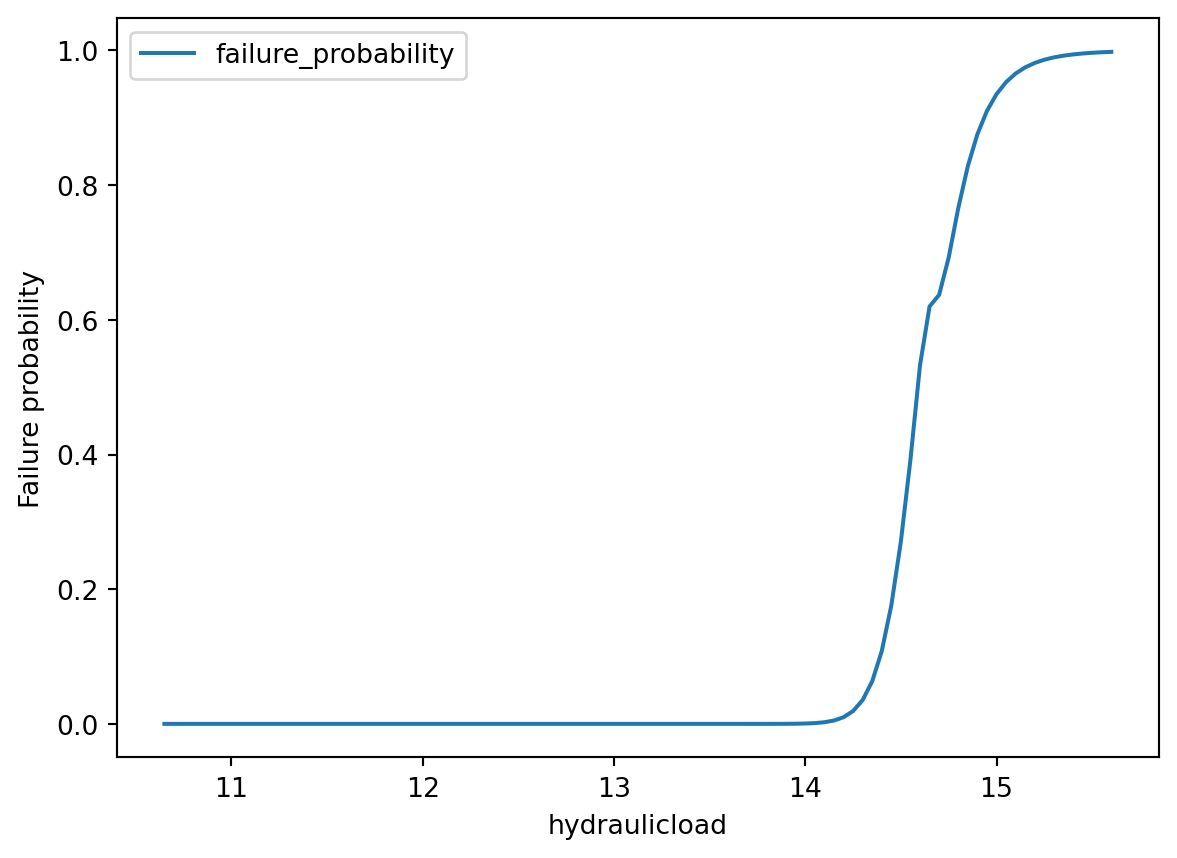

In [7]:
fig, ax = plt.subplots()
fragility_curve_overtopping.as_dataframe().set_index("hydraulicload").plot(ax=ax)
ax.set_ylabel("Failure probability");

In sommige gevallen wil je een fragility curve ook aan kunnen passen, om dit mogelijk te maken zijn verschillende functie beschikbaar die het zelfde doen als de originele functie maar een kleine, door de gebruiker opgelegde, aanpassingen doen. <br>
Zo verschuift de functie `ShiftFragilityCurveOvertoppingBedlevelFetch` de fragility curve met een effect. 

In [8]:
shift_fragility_curve_overtopping = ShiftFragilityCurveOvertoppingBedlevelFetch(
    data_adapter=data_adapter
)
shift_fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
    effect=0.5,
)

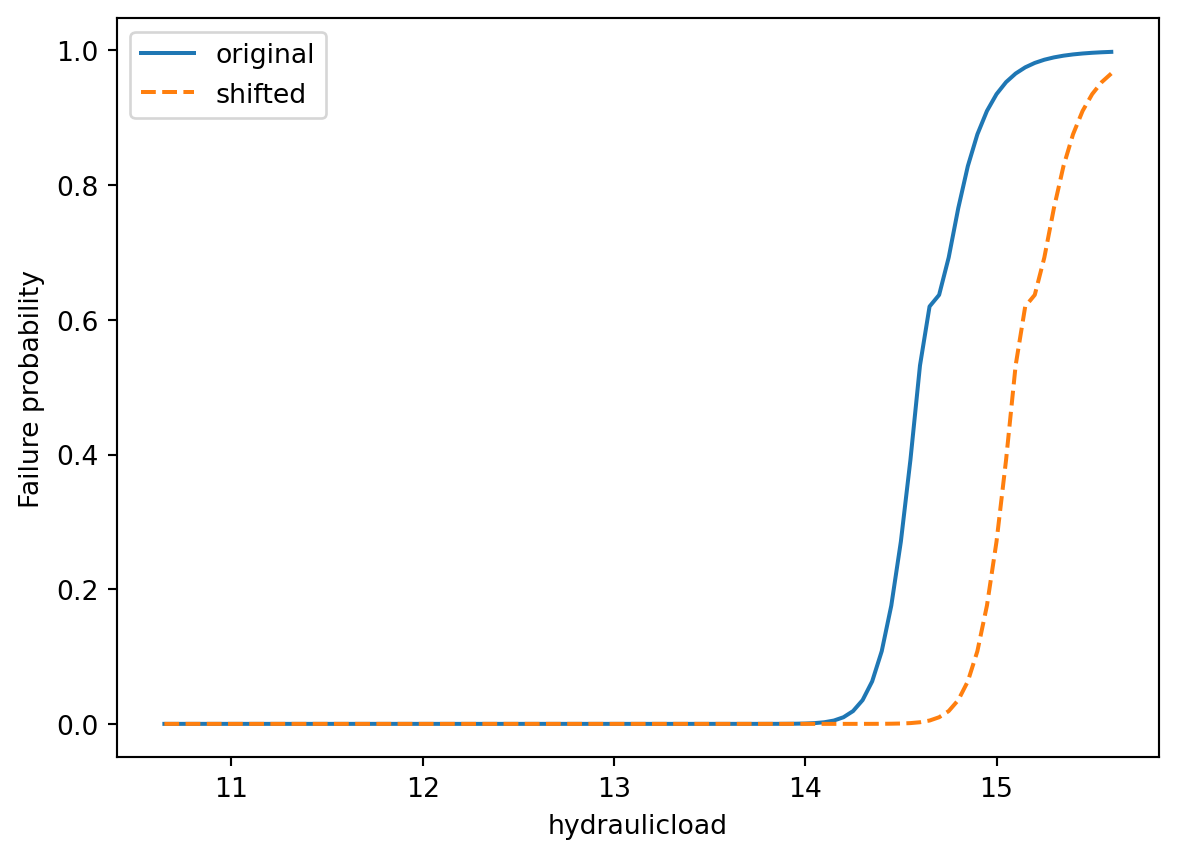

In [9]:
fig, ax = plt.subplots(1, 1)

# pas de namen van de kolommen aan voor de plot
df_overtopping = (
    fragility_curve_overtopping.as_dataframe()
    .set_index("hydraulicload")
    .rename(columns={"failure_probability": "original"})
)
df_overtopping_shift = (
    shift_fragility_curve_overtopping.as_dataframe()
    .set_index("hydraulicload")
    .rename(columns={"failure_probability": "shifted"})
)

# plotten
df_overtopping.plot(ax=ax)
df_overtopping_shift.plot(ax=ax, linestyle="--", label="shifted")
ax.set_ylabel("Failure probability");

Waar verschuiven een relatief simple nabewerking op de data is, kunnen aanpassingen aan de berekening zelf 'on-the-fly' plaatsvinden. <br>
Zo kan als maatregel de kruinhoogte worden verhoogt, met de functie `ChangeCrestHeightFragilityCurveOvertoppingBedlevelFetch` is dit mogelijk.

In [10]:
change_crest_fragility_curve_overtopping = (
    ChangeCrestHeightFragilityCurveOvertoppingBedlevelFetch(data_adapter=data_adapter)
)

change_crest_fragility_curve_overtopping.run(
    input=["slopes", "profiles", "bedlevel_fetch"],
    output="fragility_curves",
    effect=0.5,
)

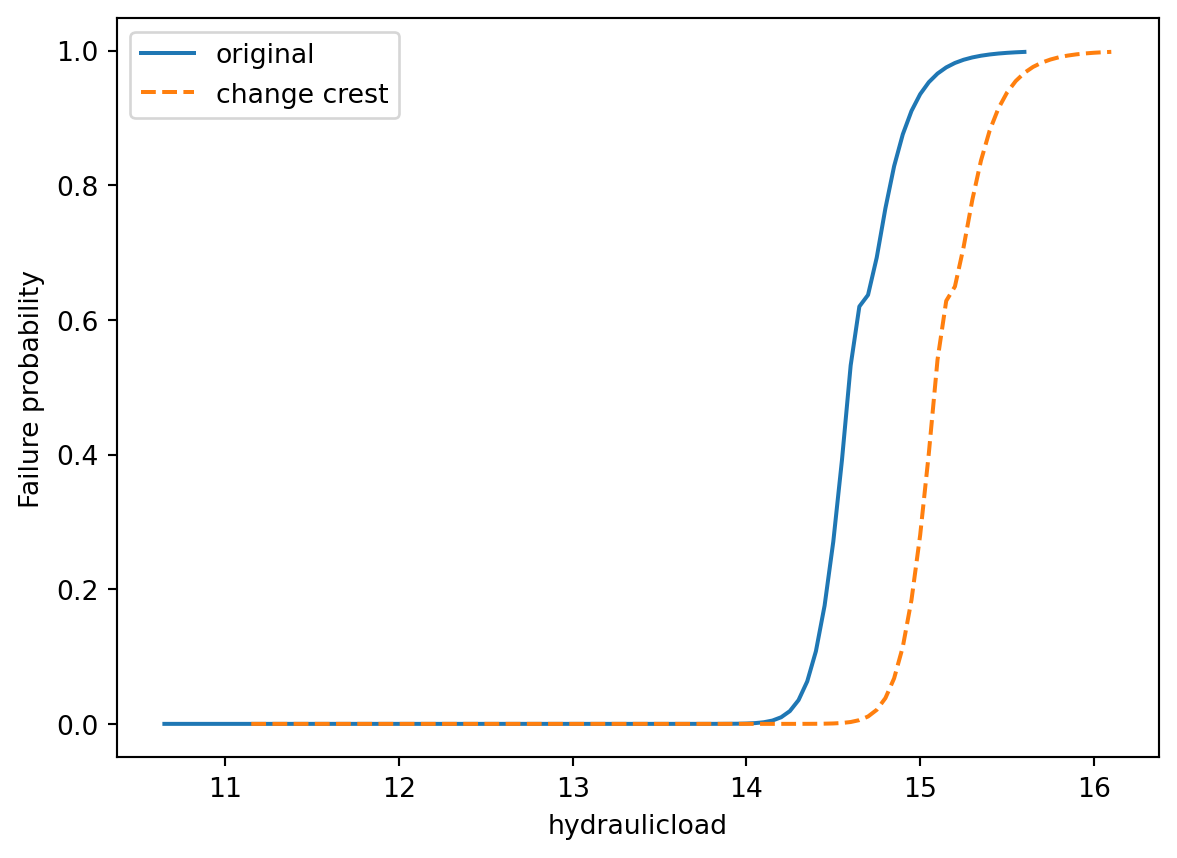

In [11]:
fig, ax = plt.subplots(1, 1)

# pas de namen van de kolom aan voor de plot
df_overtopping_change_crest = (
    change_crest_fragility_curve_overtopping.as_dataframe()
    .set_index("hydraulicload")
    .rename(columns={"failure_probability": "change crest"})
)

# plotten
df_overtopping.plot(ax=ax)
df_overtopping_change_crest.plot(ax=ax, linestyle="--")
ax.set_ylabel("Failure probability");